# Standalone Inference

- An example how to run inference on an image without the need to import `maskflow` and `maskrcnn-benchmark`.
- At the moment, `maskrcnn-benchmark`., is still required to be the Python paths during model loading and execution.
- In the future, we want to export the model as an ONNX graph to be able to run inference without any dependencies used to create the model.

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
import torch

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Nucleus")
model_dir = root_dir / "Models"

model_name = "maskrccn-nucleus-1.0.0"
model_path = model_dir / (model_name + ".pth")

In [2]:
device = 'cuda'

# Load the model
model = torch.load(model_path)
model = model.to(device)

# Load an image
fname = root_dir / "Data" / "test_dataset" / "nucleus_0071.png"
image = np.array(Image.open(fname))
image.shape

(512, 512, 3)

In [3]:
# Preprocess inputs.
# TODO: image size and intensities means should be
# set from the model configuration YAML file.

max_size = 512
pixel_means = torch.tensor([110, 110, 110], dtype=torch.float)

w, h, c = image.shape

# Crop the image
# TODO: does not work with image larger than `max_size`.
input_tensor = torch.zeros(1, 3, max_size, max_size)
input_tensor[0, :c, :w, :h] = torch.tensor([image.T])
input_tensor = input_tensor.type(torch.FloatTensor) 

# Normalize intensities
#input_tensor = input_tensor - pixel_means[None, :, None, None]

# Run inference
input_tensor = input_tensor.to(device)
predictions = model.forward(input_tensor)

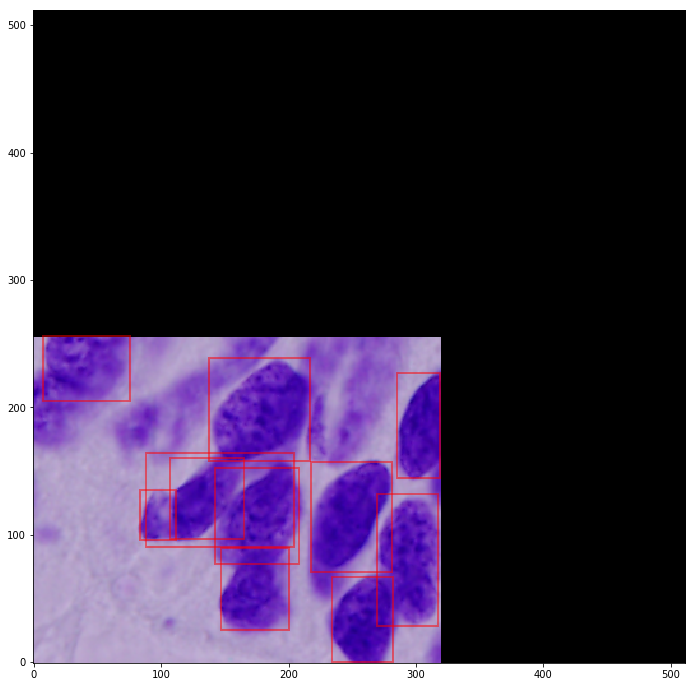

In [5]:
# Postprocess predictions.
prediction = predictions[0]

minimum_score = 0.7

boxes = prediction.bbox.to('cpu').detach().numpy()
scores = prediction.get_field('scores').to('cpu').detach().numpy()
labels = prediction.get_field('labels').to('cpu').detach().numpy()
mask = prediction.get_field('mask').to('cpu').detach().numpy()

# Keep prediction above the `minimum_score`
to_keep = np.argwhere(scores > minimum_score).T[0]
boxes = boxes[to_keep]
scores = scores[to_keep]
labels = labels[to_keep]
mask = mask[to_keep]

# Display result
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image, origin=[0, 0], interpolation='none', cmap='viridis')
ax.set_aspect('equal')

for box in boxes:
    xy = box[:2][::-1]
    h, w = box[2:] - box[:2]
    rect = patches.Rectangle(xy, w, h, color='red', alpha=0.5, fill=False, linewidth=2)
    ax.add_artist(rect)